## Predicting Peak Oil Production Rate

In this project, we will build a series of models to predict the peak oil production rate of an oil well. Predicting this quantity provides valuable
insights on the overall production profile of an oil well, which is essential for making informed decisions down the road.

## Outline

The workflow of our approach is as follows:
- Data Exploration and Pre-processing: Visualize the raw input data and observe patterns in correlation. Then, pre-process the data in a reasonable manner.
- Model Building: Construct baseline linear and non-linear models to predict the peak oil production rate.
- Evaluation: Use R-Squared and RMSE to evaluate the models and compare their performance. 
- Conclusions: Draw conclusions on performance capablity based on the evaluation phase.

## Data Exploration

There are numerous descriptive variables in our dataset. These include:
- relative_well_position
- batch_frac_classification
- frac_type
- well_family_relationship
- ffs_frac_type

First, we need to decide which of these variables we would like to keep and which ones we would like to drop. We can quickly drop frac_type since it is the same value across all data points with an existing OilPeakRate. For the others, we need to analyze them further to decide what to do with them.

In [568]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import *

# Ignore warnings
warnings.simplefilter("ignore")

# Path to the training data
training_path = "./training.csv"

Start by reading in the training data and dropping any irrelevant features. Also, drop any rows that do not have an OilPeakRate value.

In [569]:
raw_df = pd.read_csv(training_path)

DROP_COLUMNS = ["Unnamed: 0", "pad_id", "standardized_operator_name", "surface_x", "surface_y", "bh_x", "bh_y", "horizontal_midpoint_x",
                                "horizontal_midpoint_y", "horizontal_toe_x", 
                                "horizontal_toe_y", "frac_type", 
                                "frac_seasoning", "proppant_to_frac_fluid_ratio"]

AVERAGE_COLUMNS = ['average_proppant_per_stage', 'average_frac_fluid_per_stage']

raw_df = raw_df.drop(columns=DROP_COLUMNS)
raw_df = raw_df.dropna(subset=["OilPeakRate"])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       19148 non-null  float64
 1   number_of_stages              2643 non-null   float64
 2   total_proppant                17912 non-null  float64
 3   total_fluid                   17866 non-null  float64
 4   true_vertical_depth           19201 non-null  float64
 5   ffs_frac_type                 14310 non-null  object 
 6   proppant_intensity            17872 non-null  float64
 7   frac_fluid_intensity          17821 non-null  float64
 8   average_stage_length          2620 non-null   float64
 9   average_proppant_per_stage    2595 non-null   float64
 10  average_frac_fluid_per_stage  2582 non-null   float64
 11  frac_fluid_to_proppant_ratio  17501 non-null  float64
 12  bin_lateral_length            19148 non-null  float64
 13  relati

## Preliminary Visualization

Heatmap

<Axes: >

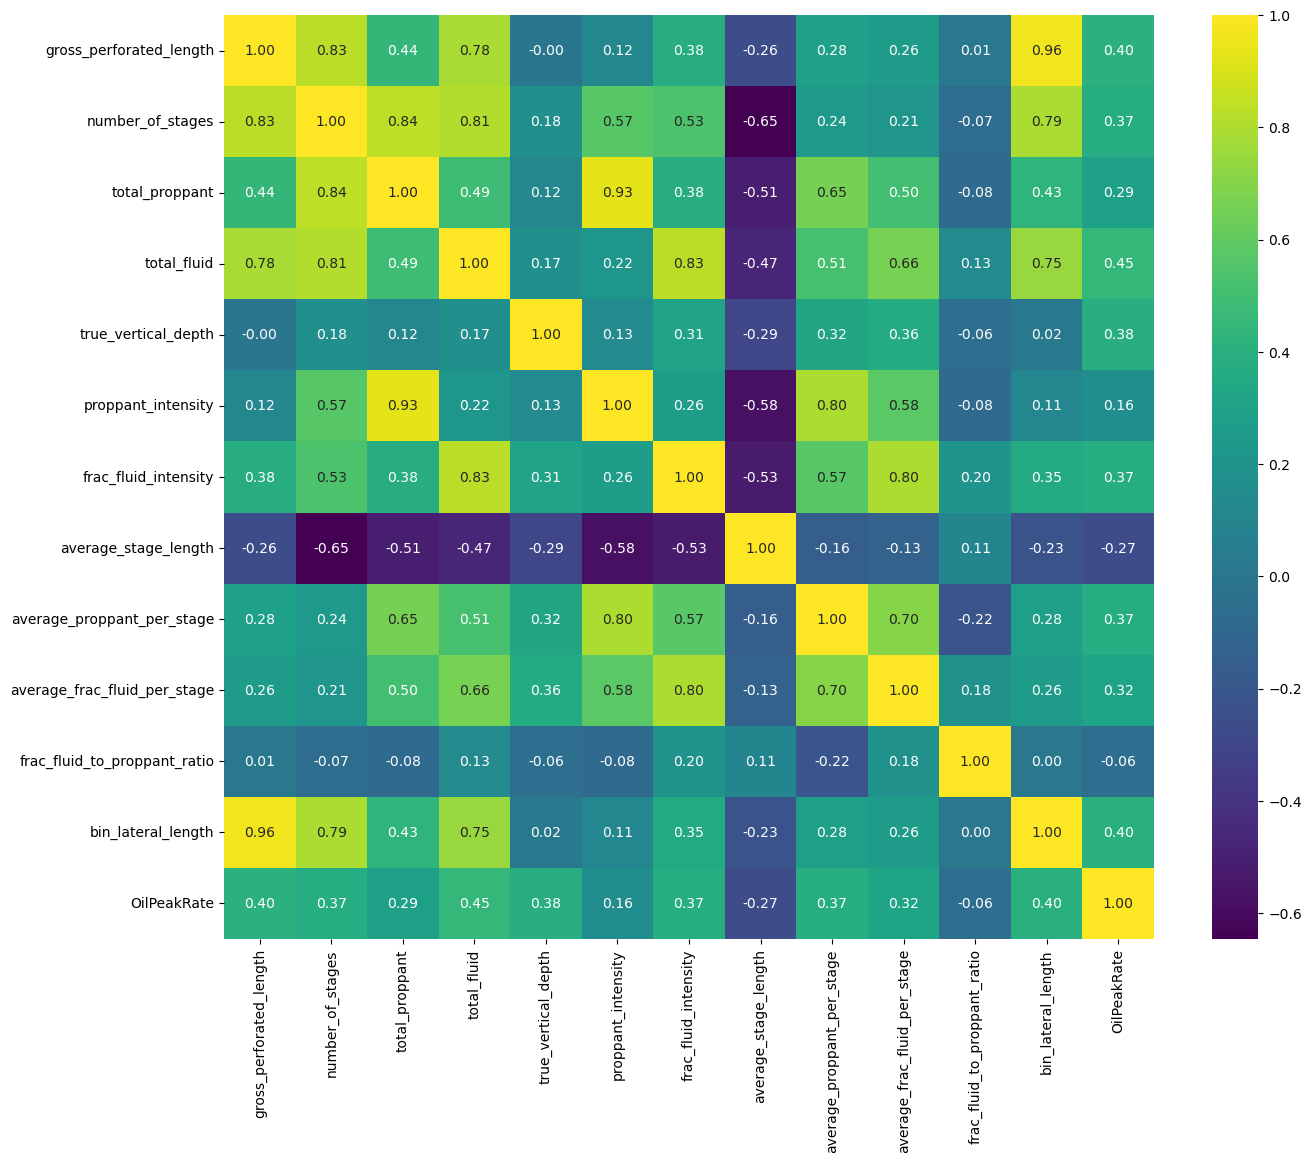

In [570]:
plt.figure(figsize=(15, 12))

# Selecting only the non-categorical variables from the DataFrame
non_categorical_data = raw_df.select_dtypes(include=[np.number])
sns.heatmap(non_categorical_data.corr(), annot=True, fmt=".2f", cmap='viridis')

Categorical Variable Analysis

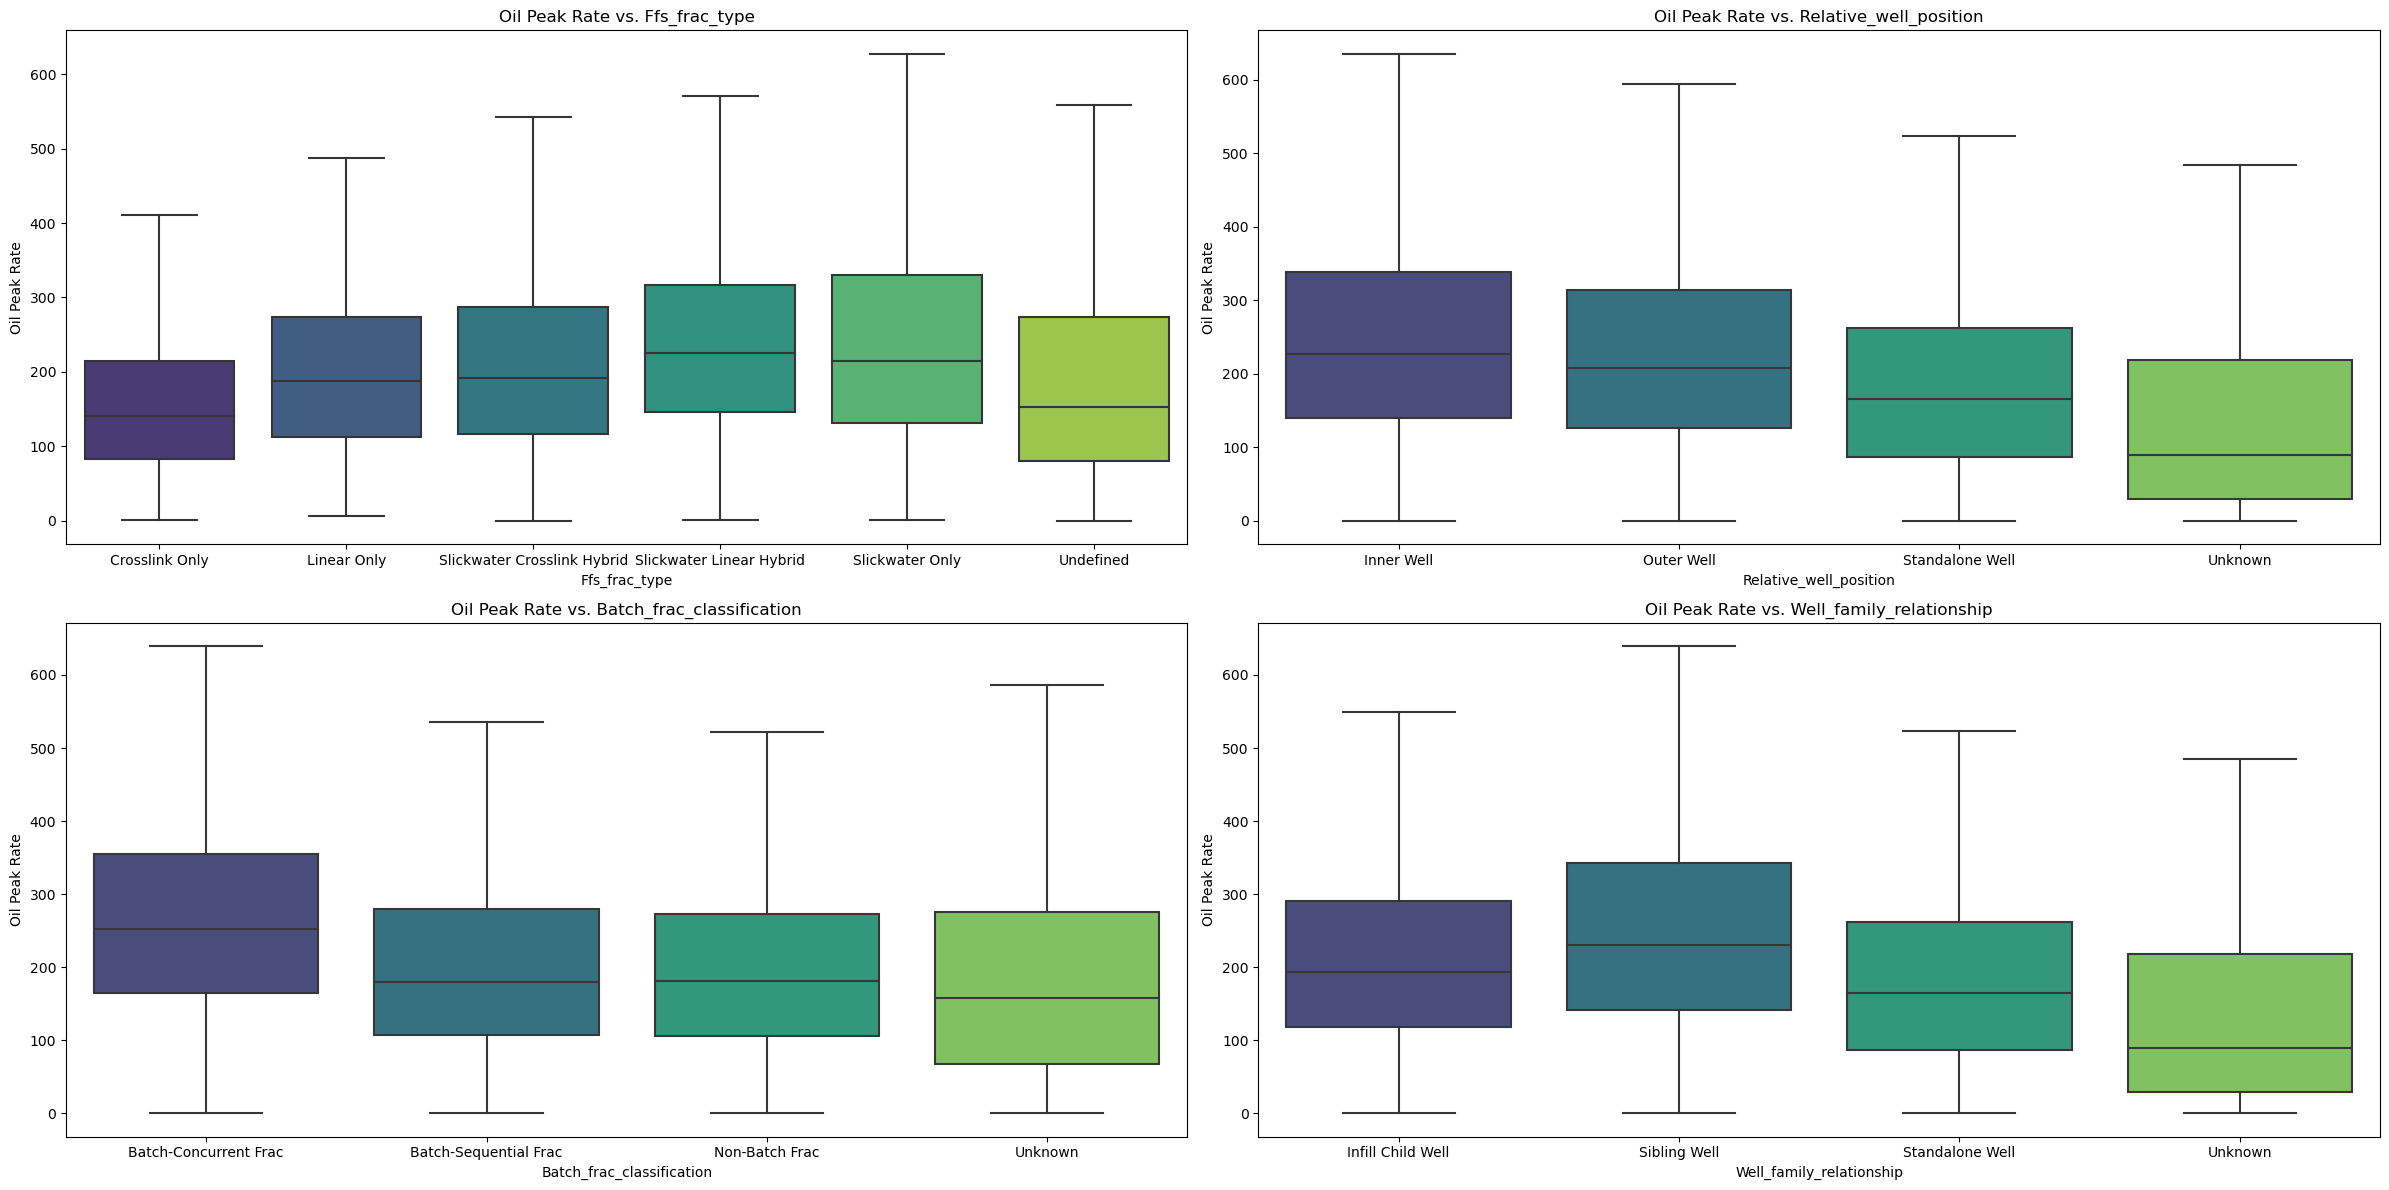

In [571]:
def visualize_categorical_variable(raw_df: pd.DataFrame, category: str, ax):
    df = raw_df.dropna(subset=[category])

    unique_values = df[category].unique()
    position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

    df[category] = df[category].replace(position_mapping)
    sns.boxplot(data=df, x=category, y='OilPeakRate', palette='viridis', showfliers=False, ax=ax)

    ax.set_title(f'Oil Peak Rate vs. {category.capitalize()}')
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel('Oil Peak Rate')

    ax.set_xticks(range(len(position_mapping)))
    ax.set_xticklabels(list(position_mapping.keys()))

fig, axs = plt.subplots(2, 2, figsize=(24, 12))

visualize_categorical_variable(raw_df, "ffs_frac_type", axs[0, 0])
visualize_categorical_variable(raw_df, "relative_well_position", axs[0, 1])
visualize_categorical_variable(raw_df, "batch_frac_classification", axs[1, 0])
visualize_categorical_variable(raw_df, "well_family_relationship", axs[1, 1])

plt.tight_layout()
plt.show()

We decided to drop ffs_frac_type and relative_well_position because we felt that these variables were either redudant with other variables and/or
didn't provide too much valuable information. For the remaining categorical variables, we encode them numerically. 

In [572]:
raw_df = raw_df.drop(columns=["ffs_frac_type", "relative_well_position"])
raw_df["batch_frac_classification"] = raw_df["batch_frac_classification"].apply(lambda x: 1 if x == 'Batch-Concurrent Frac' else 0)

unique_values = raw_df["well_family_relationship"].unique()
position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}
raw_df['well_family_relationship'] = raw_df["well_family_relationship"].replace(position_mapping)

In [573]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       19148 non-null  float64
 1   number_of_stages              2643 non-null   float64
 2   total_proppant                17912 non-null  float64
 3   total_fluid                   17866 non-null  float64
 4   true_vertical_depth           19201 non-null  float64
 5   proppant_intensity            17872 non-null  float64
 6   frac_fluid_intensity          17821 non-null  float64
 7   average_stage_length          2620 non-null   float64
 8   average_proppant_per_stage    2595 non-null   float64
 9   average_frac_fluid_per_stage  2582 non-null   float64
 10  frac_fluid_to_proppant_ratio  17501 non-null  float64
 11  bin_lateral_length            19148 non-null  float64
 12  batch_frac_classification     19306 non-null  int64  
 13  well_f

In [574]:
# See if we can find highly correlated variables.
threshold = 0.8
correlation_matrix = raw_df.corr()

high_correlations = [(column, index, correlation_matrix[column][index]) 
                     for column in correlation_matrix.columns 
                     for index in correlation_matrix.columns 
                     if (column > index) and (abs(correlation_matrix[column][index]) > threshold)]

for col, idx, corr in high_correlations:
    print(f"{col} and {idx} have a correlation of {corr:.2f}")


gross_perforated_length and bin_lateral_length have a correlation of 0.96
number_of_stages and gross_perforated_length have a correlation of 0.83
total_proppant and number_of_stages have a correlation of 0.84
total_proppant and proppant_intensity have a correlation of 0.93
total_fluid and number_of_stages have a correlation of 0.81
total_fluid and frac_fluid_intensity have a correlation of 0.83
proppant_intensity and average_proppant_per_stage have a correlation of 0.80


## Model Building

First, we attempt to build a model that only includes rows with all available data.

In [575]:
from sklearn.model_selection import train_test_split

raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
raw_df = raw_df.drop(columns=AVERAGE_COLUMNS)
all_variables_df = raw_df.dropna()

print(all_variables_df.info())
all_variables_df.to_csv("./cleaned_data.csv", index=False)
X = all_variables_df.drop(["OilPeakRate"], axis=1)
y = all_variables_df["OilPeakRate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)
train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

train_data

<class 'pandas.core.frame.DataFrame'>
Index: 2542 entries, 2 to 29431
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       2542 non-null   float64
 1   number_of_stages              2542 non-null   float64
 2   total_proppant                2542 non-null   float64
 3   total_fluid                   2542 non-null   float64
 4   true_vertical_depth           2542 non-null   float64
 5   proppant_intensity            2542 non-null   float64
 6   frac_fluid_intensity          2542 non-null   float64
 7   average_stage_length          2542 non-null   float64
 8   frac_fluid_to_proppant_ratio  2542 non-null   float64
 9   bin_lateral_length            2542 non-null   float64
 10  batch_frac_classification     2542 non-null   int64  
 11  well_family_relationship      2542 non-null   int64  
 12  OilPeakRate                   2542 non-null   float64
dtypes: floa

,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,average_stage_length,frac_fluid_to_proppant_ratio,bin_lateral_length,batch_frac_classification,well_family_relationship,OilPeakRate
21690,6320.866142,36.0,5.295275e+05,3.863094e+06,7503.937008,83.774516,611.165236,175.579615,7.295360,1.5,0,2,95.669459
21885,9218.503937,48.0,1.132533e+06,4.880765e+06,7728.346457,122.854316,529.453021,192.052165,4.309600,2.0,1,1,140.119069
4092,3974.409449,28.0,4.923324e+05,2.622864e+06,9443.897638,123.875619,659.938021,141.943195,5.327425,1.0,0,2,170.464312
5459,9622.047244,49.0,1.123106e+06,6.565680e+06,8882.874016,116.722153,682.357869,196.368311,5.846001,2.0,1,0,432.621551
1362,4028.543307,10.0,2.175571e+05,8.816671e+05,7401.574803,54.003905,218.855057,402.854331,4.052578,1.0,0,2,89.571442
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,6663.385827,22.0,2.117922e+05,8.358993e+05,9724.409449,31.784474,125.446625,302.881174,3.946789,1.5,0,2,98.936515
6435,9615.157480,55.0,1.392732e+06,7.012908e+06,9440.944882,144.847587,729.359641,174.821045,5.035359,2.0,0,2,107.500017
19770,10086.614170,50.0,1.525744e+06,8.001399e+06,8963.582677,151.264195,793.269080,201.732283,5.244262,2.0,1,1,534.844313
16375,7190.944882,50.0,6.951301e+05,3.482121e+06,9300.196850,96.667418,484.236962,143.818898,5.009309,1.5,1,1,321.107193


array([[<Axes: title={'center': 'gross_perforated_length'}>,
        <Axes: title={'center': 'number_of_stages'}>,
        <Axes: title={'center': 'total_proppant'}>,
        <Axes: title={'center': 'total_fluid'}>],
       [<Axes: title={'center': 'true_vertical_depth'}>,
        <Axes: title={'center': 'proppant_intensity'}>,
        <Axes: title={'center': 'frac_fluid_intensity'}>,
        <Axes: title={'center': 'average_stage_length'}>],
       [<Axes: title={'center': 'frac_fluid_to_proppant_ratio'}>,
        <Axes: title={'center': 'bin_lateral_length'}>,
        <Axes: title={'center': 'batch_frac_classification'}>,
        <Axes: title={'center': 'well_family_relationship'}>],
       [<Axes: title={'center': 'OilPeakRate'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

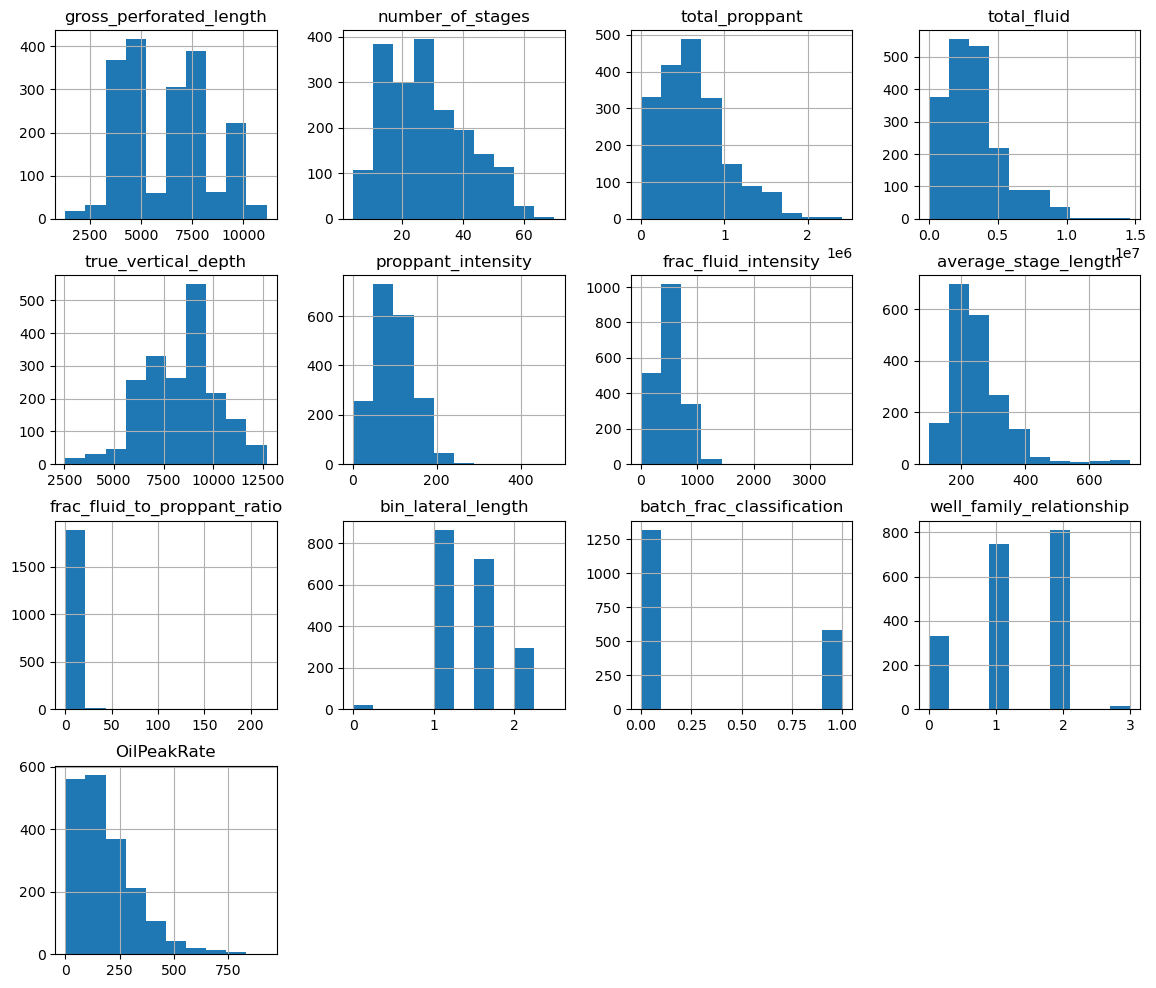

In [576]:
train_data.hist(figsize=(14, 12))

Start with a basic linear regression model

In [577]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Scale the input data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Fit a Lasso Regression model
alpha = 0.05
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train_s, y_train)

Lasso(alpha=0.05)

In [578]:
lasso_score = round(lasso_reg.score(X_test_s, y_test), 3)
lasso_score

0.417

In [579]:
from sklearn.metrics import mean_squared_error
y_pred = lasso_reg.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", round(rmse, 3))

Root Mean Squared Error (RMSE): 97.023


Finish with some non-linear models

In [580]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

forest = RandomForestRegressor()

param_dist =  {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
random_search = GridSearchCV(estimator=forest, param_grid=param_dist, n_jobs=-1)

random_search.fit(X_train_s, y_train)
best_params = random_search.best_params_
print("Best parameters found: ", best_params)
best_forest = RandomForestRegressor(**best_params)

# Fit the model with the best parameters
best_forest.fit(X_train_s, y_train)

Best parameters found:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


RandomForestRegressor(min_samples_split=5)

In [581]:
forest_score = round(best_forest.score(X_test_s, y_test), 3)
forest_score

0.635

In [582]:
y_pred = best_forest.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)

# Calculate and print the RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", round(rmse, 3))

Root Mean Squared Error (RMSE): 76.796


Display actual values and predicted values in a scatterplot.

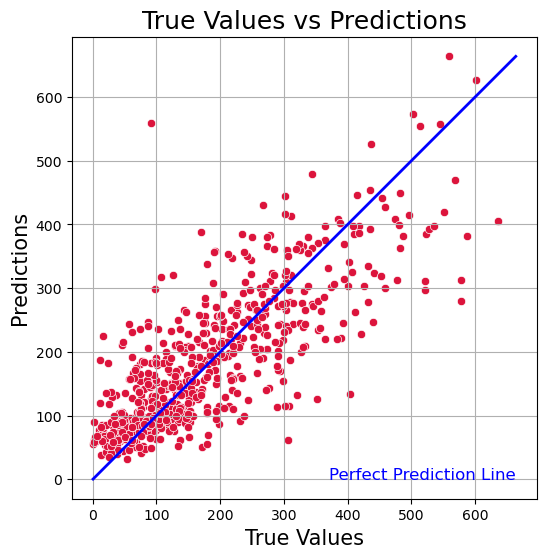

In [583]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, color='crimson')

# Plotting a line representing perfect predictions
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-', linewidth=2)

plt.title('True Values vs Predictions', fontsize=18)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.grid(True)
plt.axis('equal')

plt.text(p1, p2, 'Perfect Prediction Line', color='blue', fontsize=12, ha='right')
plt.show()

Compare their distributions in side-by-side histograms.

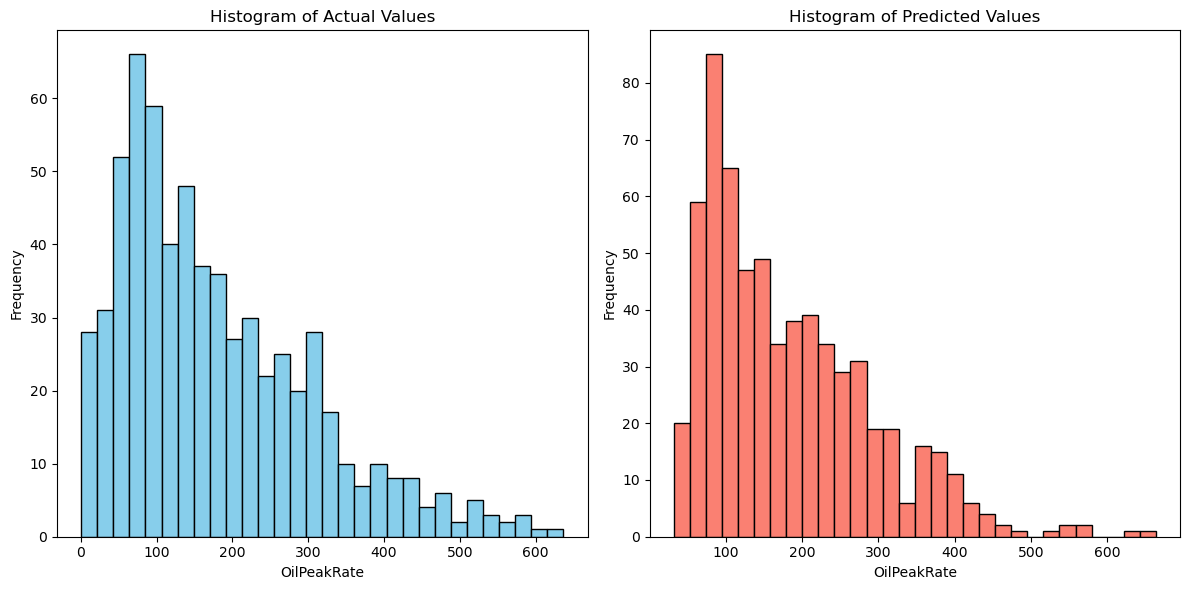

In [584]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Histogram of Actual Values
axs[0].hist(y_test, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Actual Values')
axs[0].set_xlabel('OilPeakRate')
axs[0].set_ylabel('Frequency')

# Histogram of Predicted Values
axs[1].hist(y_pred, bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Histogram of Predicted Values')
axs[1].set_xlabel('OilPeakRate')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Final Testing

In [585]:
# Replace with the name of the actual training file on Sunday morning!
TESTING_PATH = "./training.csv"

testing_df = pd.read_csv(TESTING_PATH)
testing_df = testing_df.drop(columns=DROP_COLUMNS, errors='ignore')
testing_df = testing_df.drop(columns=AVERAGE_COLUMNS, errors='ignore')
testing_df = testing_df.drop(columns=["ffs_frac_type", "relative_well_position"], errors='ignore')
testing_df["batch_frac_classification"] = raw_df["batch_frac_classification"].apply(lambda x: 1 if x == 'Batch-Concurrent Frac' else 0)

# Uncomment this line in case of np.inf encounters
# testing_df.replace([np.inf, -np.inf], np.nan, inplace=True)

testing_df = testing_df.dropna(subset=["well_family_relationship"])
unique_values = testing_df["well_family_relationship"].unique()
position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}
testing_df['well_family_relationship'] = testing_df["well_family_relationship"].replace(position_mapping)

testing_df = testing_df.drop(columns=["OilPeakRate"], errors='ignore')
testing_df = testing_df.dropna()
testing_df = scaler.fit_transform(testing_df)

# Make the prediction!
testing_predictions = best_forest.predict(testing_df)
testing_predictions_df = pd.DataFrame(testing_predictions, columns=["OilPeakRate"])
testing_predictions_df.to_excel("./Submissions/submission_file.xlsx", index=False)